# Imports

In [773]:
import pandas as pd
pd.set_option('display.max_rows', 500)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedKFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from collections import defaultdict

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator

!pip install optbinning
from optbinning import BinningProcess

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.calibration import calibration_curve

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import optuna

In [774]:
train_df = pd.read_parquet('/kaggle/input/alpha-contest/train.parquet').set_index('id')

# Data cleaning

## Data is noised!

In this contest data is anonymized by appling random noise. During the EDA process we understood that for some variable the noise was gaussian. As for clear example, we can take discrete variable 'cnt_days_deb_e_oper_1m'.

<Axes: xlabel='cnt_days_deb_e_oper_1m', ylabel='Count'>

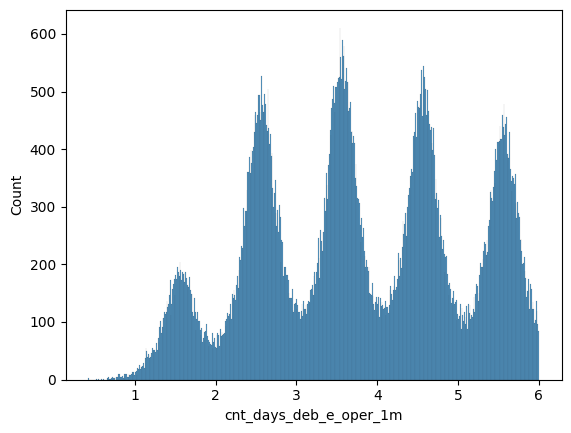

In [775]:
feature = train_df['cnt_days_deb_e_oper_1m']
sns.histplot(feature[(feature > -1) & (feature < 6)], binwidth=0.01)

Thus, our feature is a mixture of gaussian distributions with mean near the true value of this variable (discrete values: 0, 1, 2, 3 ...). But why is it so important? Quick inspection of features ranges showed us that there are outliers that can be a result of technical mistake (like more than 31 days in month). 

- Thus our filtering boundaries should be less strict to take into account noise. 
- In addition to this, our findings means that number of unique values for each feature should be inspected manually, because near-const feature after noising, can suddenly have a lot of unique values.

## Examples of Negative and Large Values

In [776]:
(train_df['rko_start_months'] < 0).sum()

30542

In [777]:
(train_df['cnt_days_cred_h_oper_3m'] > 31).sum()

25312

Boundaries for each numeric feature will be discussed in the next section! Technical outliers will be mapped to NaN where.

# Numeric Features

## NaN check

In [778]:
(train_df.select_dtypes(include='number').isna()).sum()

rko_start_months                  59
max_end_fact_fin_deals        313574
max_end_plan_non_fin_deals    345094
max_start_fin_deals           315677
max_start_non_fin_deals       343958
min_end_fact_fin_deals        315677
min_end_plan_non_fin_deals    343924
min_start_fin_deals           314637
min_start_non_fin_deals       343951
balance_amt_avg                 1045
balance_amt_max                 1047
balance_amt_min                 1046
balance_amt_day_avg             1040
ogrn_days_end_month              432
ogrn_days_end_quarter            433
ft_registration_date             799
max_founderpres               210723
min_founderpres               209313
ogrn_exist_months                433
sum_of_paym_2m                 13059
sum_of_paym_6m                 13041
sum_of_paym_1y                 13136
sum_a_oper_1m                      0
cnt_a_oper_1m                   6496
sum_b_oper_1m                      0
cnt_b_oper_1m                   6495
sum_c_oper_1m                      0
c

2 interesting things drew our eyes:

- There are feature with a half of NaN values, this features might be dropped or replaced with NaN indicator column
- Some of features (with cnt in their name) have suspiciously equal number of missing values - the assumption is that it the same cluster of people.

## Same number of nans

In [779]:
cnt_columns = [col for col in train_df.columns if 'cnt' in col]

In [780]:
nan_people = train_df[train_df[cnt_columns].isna().any(axis=1)]
nan_people.isna().sum().loc[cnt_columns]

cnt_a_oper_1m              6496
cnt_b_oper_1m              6495
cnt_c_oper_1m              6496
cnt_deb_d_oper_1m          6521
cnt_cred_d_oper_1m         6442
cnt_deb_e_oper_1m          6489
cnt_days_deb_e_oper_1m     6460
cnt_cred_e_oper_1m         6492
cnt_days_cred_e_oper_1m    6485
cnt_deb_f_oper_1m          6485
cnt_days_deb_f_oper_1m     6521
cnt_cred_f_oper_1m         6496
cnt_days_cred_f_oper_1m    6521
cnt_deb_g_oper_1m          6500
cnt_days_deb_g_oper_1m     6490
cnt_cred_g_oper_1m         6521
cnt_days_cred_g_oper_1m    6495
cnt_deb_h_oper_1m          6474
cnt_days_deb_h_oper_1m     6496
cnt_cred_h_oper_1m         6489
cnt_days_cred_h_oper_1m    6521
cnt_a_oper_3m              3697
cnt_b_oper_3m              3697
cnt_c_oper_3m              3710
cnt_deb_d_oper_3m          3685
cnt_cred_d_oper_3m         3687
cnt_deb_e_oper_3m          3693
cnt_days_deb_e_oper_3m     3679
cnt_cred_e_oper_3m         3691
cnt_days_cred_e_oper_3m    3685
cnt_deb_f_oper_3m          3694
cnt_days

In [781]:
nan_people.shape

(6521, 102)

There are 6521 entries that have NaNs for all cnt features. In addition to this, these people have additional columns with NaN values and strange operation sum values, for example 'sum_cred_f_oper_1m. Due to noise factor, round values of sum features will be showed to see the approximate number of unique values for each column.That's why we decided to drop these people.

In [782]:
nan_people['sum_deb_g_oper_1m'].round().value_counts()

sum_deb_g_oper_1m
2215.0    6521
Name: count, dtype: int64

In [783]:
nan_people['sum_cred_g_oper_1m'].round().value_counts()

sum_cred_g_oper_1m
6.0    5852
5.0     592
7.0      77
Name: count, dtype: int64

In [784]:
nan_people['sum_cred_e_oper_1m'].round().value_counts()

sum_cred_e_oper_1m
 5.037500e+04    6495
-4.533780e+05      15
 4.131863e+10      11
Name: count, dtype: int64

In [785]:
nan_people['sum_a_oper_1m'].round().value_counts()

sum_a_oper_1m
 317.0         4147
 316.0         2217
 318.0           98
-2510.0          19
 315.0           17
 90001513.0      12
-2259.0           6
 81001362.0       5
Name: count, dtype: int64

In [786]:
nan_people['sum_b_oper_1m'].round().value_counts()

sum_b_oper_1m
 8.650000e+02    5876
 8.660000e+02     483
 8.640000e+02     102
 4.284215e+10      18
 3.855794e+10      16
-2.217000e+03      13
-2.463000e+03      13
Name: count, dtype: int64

## Number of days for certain operation

There is a subset of feature that indicate number of days in a given period, when certain operation has occured. For example 'cnt_days_cred_g_oper_1m' or 'cnt_days_deb_f_oper_3m'.  It's obvious that these values are bounded by 0 and the length of a period in days. There are 2 periods in the data, thus we will have 31 and 93 as upper bounds. 

But as we discussed earlier they must be corrected according to noise process. We suggest -2 for lower bound and 35, 100 for upper bounds.

In [787]:
cnt_days_features = [col for col in train_df.columns if 'cnt_days' in col]
cnt_days_features

['cnt_days_deb_e_oper_1m',
 'cnt_days_cred_e_oper_1m',
 'cnt_days_deb_f_oper_1m',
 'cnt_days_cred_f_oper_1m',
 'cnt_days_deb_g_oper_1m',
 'cnt_days_cred_g_oper_1m',
 'cnt_days_deb_h_oper_1m',
 'cnt_days_cred_h_oper_1m',
 'cnt_days_deb_e_oper_3m',
 'cnt_days_cred_e_oper_3m',
 'cnt_days_deb_f_oper_3m',
 'cnt_days_cred_f_oper_3m',
 'cnt_days_deb_g_oper_3m',
 'cnt_days_cred_g_oper_3m',
 'cnt_days_deb_h_oper_3m',
 'cnt_days_cred_h_oper_3m']

### 1 month period

In [788]:
cnt_days_one_features = [col for col in cnt_days_features if '1m' in col]
cnt_days_one_df = train_df[cnt_days_one_features]

In [789]:
(cnt_days_one_df < -2).sum()

cnt_days_deb_e_oper_1m     1189
cnt_days_cred_e_oper_1m    1193
cnt_days_deb_f_oper_1m        0
cnt_days_cred_f_oper_1m       0
cnt_days_deb_g_oper_1m      592
cnt_days_cred_g_oper_1m     597
cnt_days_deb_h_oper_1m      600
cnt_days_cred_h_oper_1m       0
dtype: int64

In [790]:
(cnt_days_one_df > 35).sum()

cnt_days_deb_e_oper_1m     1186
cnt_days_cred_e_oper_1m    1204
cnt_days_deb_f_oper_1m        0
cnt_days_cred_f_oper_1m       0
cnt_days_deb_g_oper_1m      594
cnt_days_cred_g_oper_1m     589
cnt_days_deb_h_oper_1m      600
cnt_days_cred_h_oper_1m       0
dtype: int64

As we can see we can have both negative and big outliers. Let's take an example of one column.

In [791]:
cnt_days_one_df.loc[cnt_days_one_df['cnt_days_deb_e_oper_1m'] > 35, 'cnt_days_deb_e_oper_1m']

id
76        339.297541
291       339.297541
1027      271.438033
1052      271.438033
1084      339.297541
             ...    
358346    271.438033
358446    271.438033
359352    339.297541
359634    339.297541
359923    339.297541
Name: cnt_days_deb_e_oper_1m, Length: 1186, dtype: float64

These are tremendous values. As we can see our boundaries do great job dealing with unreal outliers.

In [792]:
def clear_columns(df, lower, upper):
    
    for col in df.columns:
        df.loc[(df[col] < -2) | (df[col] > 35), col] = np.NaN
        
    return df

In [793]:
cnt_days_one_df = clear_columns(cnt_days_one_df, -2, 35)

/tmp/ipykernel_47/1980775911.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df[col] < -2) | (df[col] > 35), col] = np.NaN


In [794]:
def plot_hists_clipped(df, binwidth):
    n_charts = df.shape[1]
               
    fig, axarr = plt.subplots(nrows = n_charts, figsize=(8, n_charts*4))

    for i in range(n_charts):

        feature = df.iloc[:, i]
        
        if type(axarr) == np.ndarray:
            cur_ax = axarr[i]
        else:
            cur_ax = axarr
            
        sns.histplot(feature, ax=cur_ax, binwidth=binwidth)

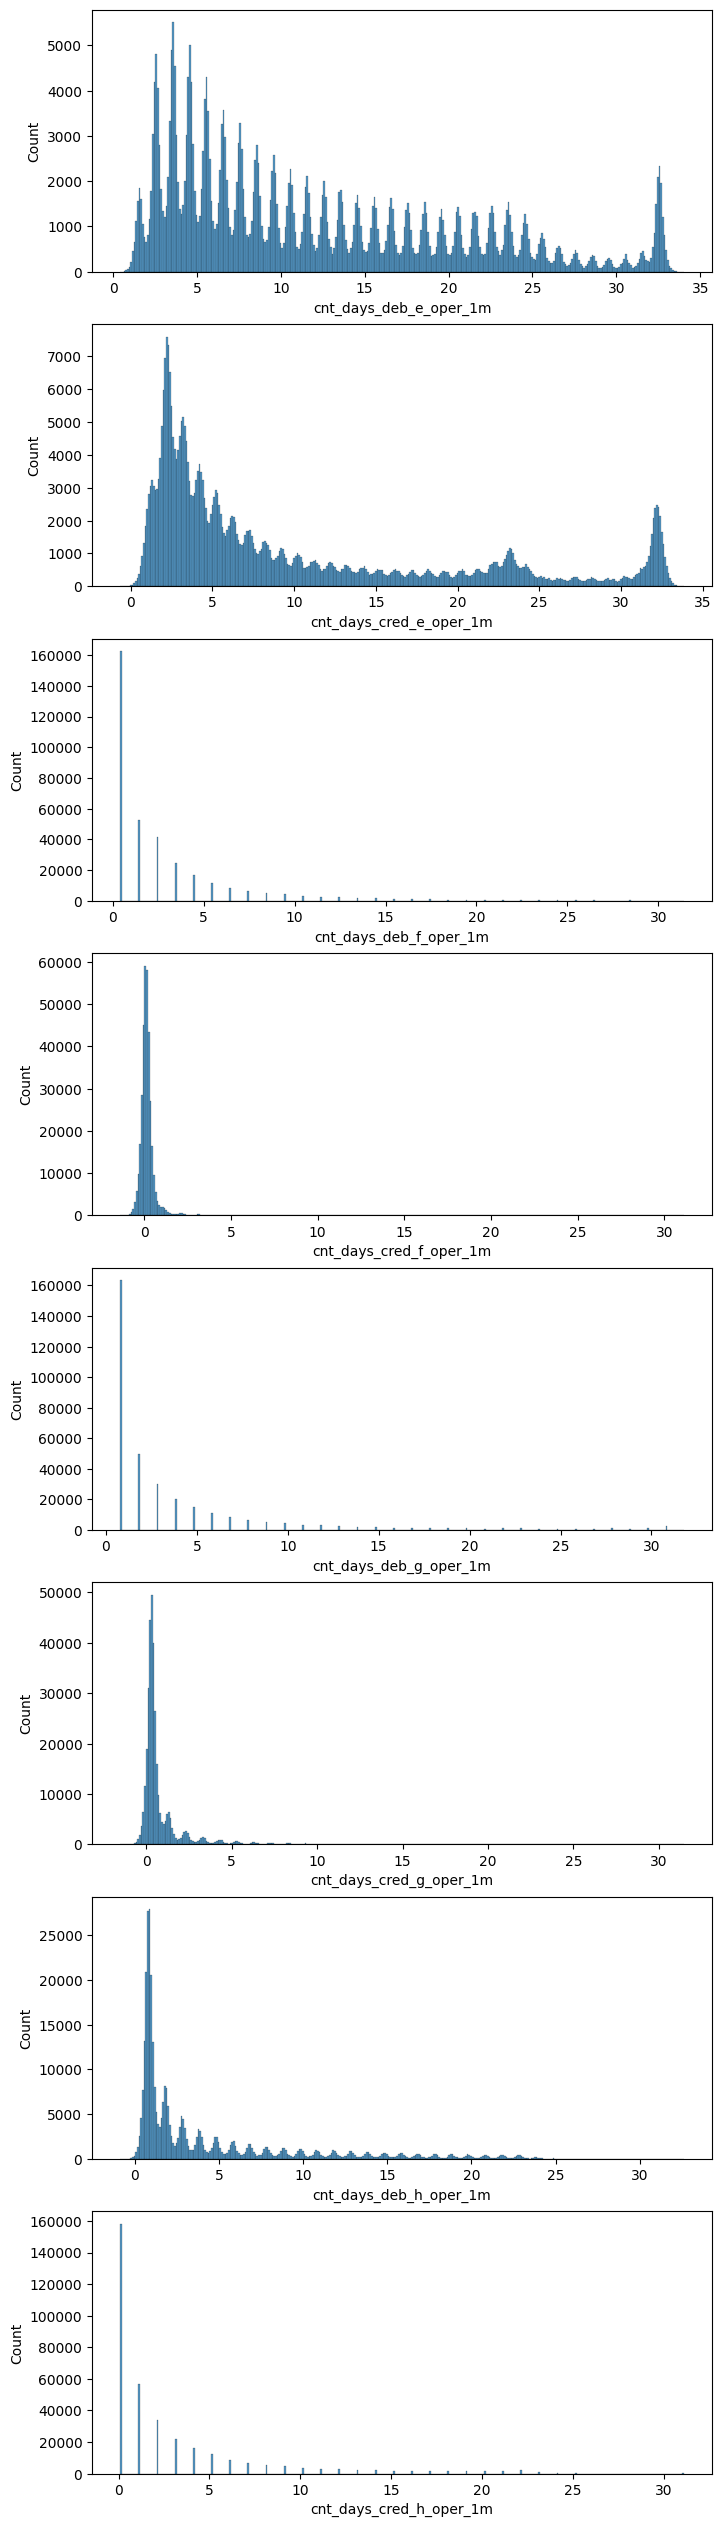

In [795]:
plot_hists_clipped(cnt_days_one_df, 0.1)

In [796]:
cnt_days_one_df.std()

cnt_days_deb_e_oper_1m     8.519220
cnt_days_cred_e_oper_1m    9.510181
cnt_days_deb_f_oper_1m     3.924656
cnt_days_cred_f_oper_1m    1.024250
cnt_days_deb_g_oper_1m     6.959027
cnt_days_cred_g_oper_1m    2.613288
cnt_days_deb_h_oper_1m     5.534490
cnt_days_cred_h_oper_1m    4.520488
dtype: float64

- All distribution after removing outliers look like an expontial distribution.
- It looks like cnt_days_cred_f_oper_1m' before appling noise could take small number of values (like 0, 1, 2), we can consider to drop these feature, because our model can start to learn something from the noise of that variable, while in reality it almost always equal to 0. It's low variance proves out theory.
- Maybe Binarization of continuous variables is required for removing undesireble noise. For the number of bins we could take the original number of unique values before applying noise. As for the method, I think 1-d KMeans clustering would work, because centroid will be chosen at the chart picks

## 3 month period

Let's repeat all but with longer period

In [797]:
cnt_days_three_features = [col for col in cnt_days_features if '3m' in col]
cnt_days_three_df = train_df[cnt_days_three_features]

In [798]:
(cnt_days_three_df < -2).sum()

cnt_days_deb_e_oper_3m     1180
cnt_days_cred_e_oper_3m    1209
cnt_days_deb_f_oper_3m     1190
cnt_days_cred_f_oper_3m    1758
cnt_days_deb_g_oper_3m      591
cnt_days_cred_g_oper_3m       0
cnt_days_deb_h_oper_3m     1770
cnt_days_cred_h_oper_3m     596
dtype: int64

In [799]:
(cnt_days_three_df > 100).sum()

cnt_days_deb_e_oper_3m     1272
cnt_days_cred_e_oper_3m    1174
cnt_days_deb_f_oper_3m     1173
cnt_days_cred_f_oper_3m    1802
cnt_days_deb_g_oper_3m      595
cnt_days_cred_g_oper_3m       0
cnt_days_deb_h_oper_3m     1790
cnt_days_cred_h_oper_3m     581
dtype: int64

In [800]:
cnt_days_three_df = clear_columns(cnt_days_three_df, -2, 100)

/tmp/ipykernel_47/1980775911.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df[col] < -2) | (df[col] > 35), col] = np.NaN


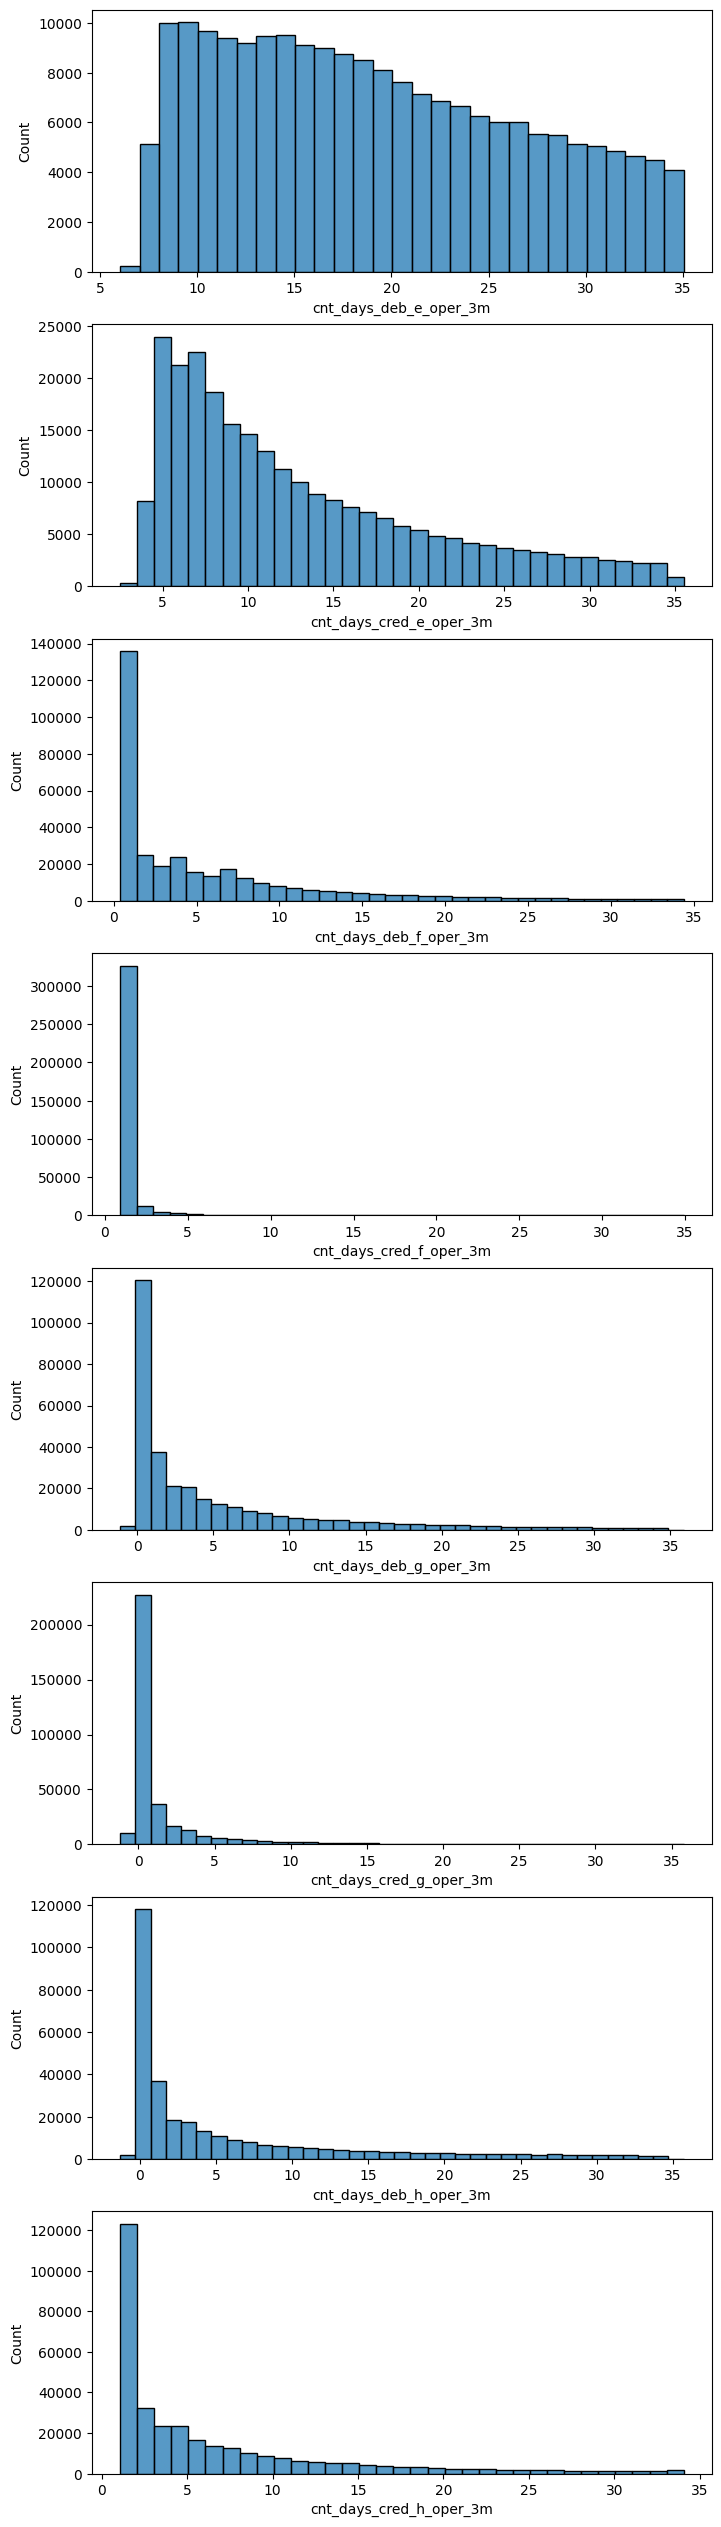

In [801]:
plot_hists_clipped(cnt_days_three_df, 1)

In [802]:
cnt_days_three_df.std()

cnt_days_deb_e_oper_3m     7.617489
cnt_days_cred_e_oper_3m    7.761125
cnt_days_deb_f_oper_3m     6.912545
cnt_days_cred_f_oper_3m    1.732997
cnt_days_deb_g_oper_3m     7.219633
cnt_days_cred_g_oper_3m    4.336838
cnt_days_deb_h_oper_3m     8.381388
cnt_days_cred_h_oper_3m    7.091411
dtype: float64

Same insights - exponential distributions for all features, low-variance cnt_days_cred_f_oper_3m, usage of binning.

## Features - ogrn_days_end_month and ogrn_days_end_quarter

Same logic can be applied for these 2 features. They still bounded by 0, and upper bounds are month (31) and quarter (93)

In [803]:
ogrn_days_month, ogrn_days_quarter = train_df['ogrn_days_end_month'], train_df['ogrn_days_end_quarter']

In [804]:
(ogrn_days_month < -2).sum()

607

In [805]:
(ogrn_days_month > 35).sum()

590

<Axes: xlabel='ogrn_days_end_month', ylabel='Count'>

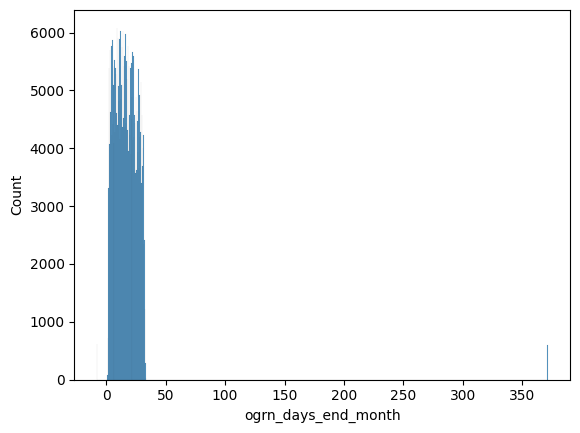

In [806]:
sns.histplot(ogrn_days_month)

ogrn_days_end_month needs removing technical outliers.

<Axes: xlabel='ogrn_days_end_quarter', ylabel='Count'>

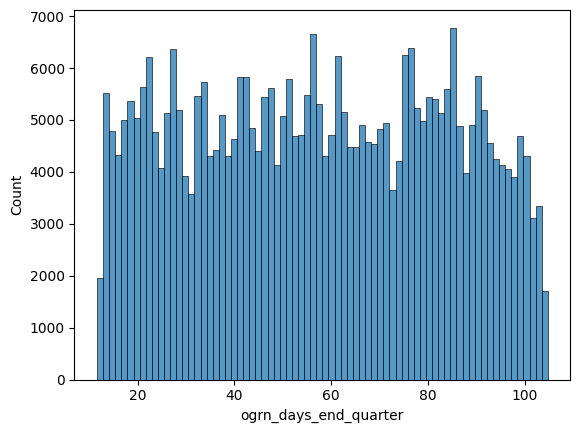

In [807]:
sns.histplot(ogrn_days_quarter)

This feature on the other hand doesn't any addtional preprocessing.

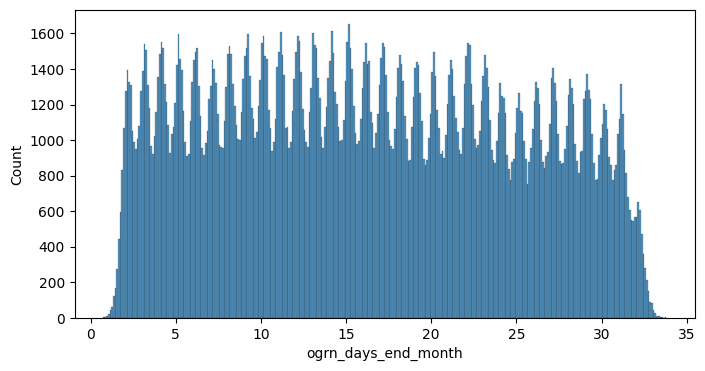

In [808]:
ogrn_days_month = clear_columns(ogrn_days_month.to_frame(), -2, 35)
plot_hists_clipped(ogrn_days_month, 0.1)

As for their correlation to target, the first opinion was that these periodic features don't carry any information about behaviour pattern. In fact, box plots for these variable across target values prove it!

<Axes: xlabel='total_target', ylabel='ogrn_days_end_month'>

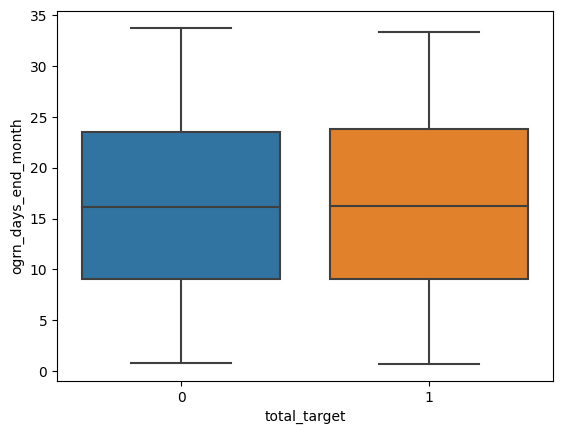

In [809]:
sns.boxplot(x=train_df['total_target'], y=train_df['ogrn_days_end_month'])

## rko_start_month

<Axes: xlabel='total_target', ylabel='rko_start_months'>

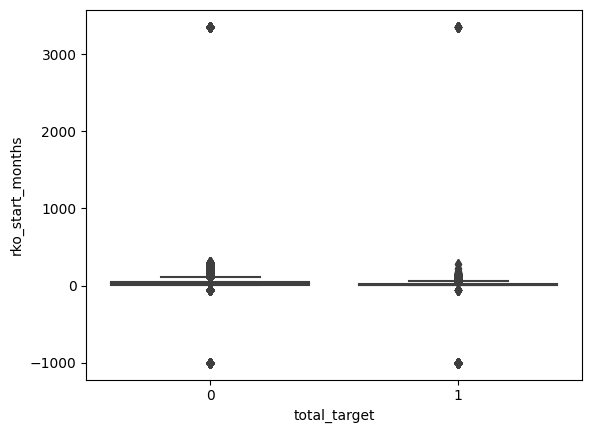

In [810]:
sns.boxplot(x=train_df['total_target'], y=train_df['rko_start_months'])

Alpha Bank was founded in 1990, so the upper bound will be 792 months (33 years * 12 months)

In [811]:
clipped_rko = train_df.loc[(train_df['rko_start_months'] > 0) & (train_df['rko_start_months'] < 792)]

<Axes: xlabel='total_target', ylabel='rko_start_months'>

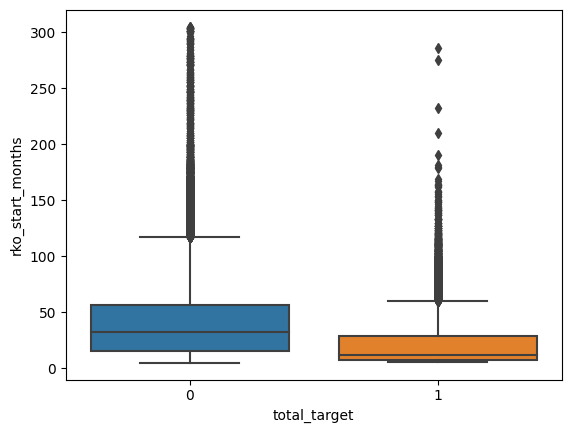

In [812]:
sns.boxplot(x=clipped_rko['total_target'], y=clipped_rko['rko_start_months'])

## Other numerical features

For these features only lower bound -2 will be used. As for upper bound we don't have any logic explanation, because of lack of domain knowledge, so we derive it from data. The reason to remove tremendous outliers lies in a problem of interpretability of our model. Let's take an examples.

In [813]:
def scatter_and_corr(df, column1, column2):
    sns.scatterplot(x=df[column1], y=df[column2])
    print(f"Correlation = {df[[column1, column2]].corr().iloc[1,0]}")

Correlation = 0.48705497142413456


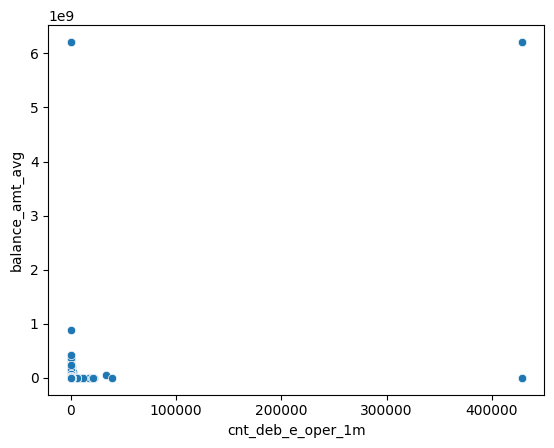

In [814]:
scatter_and_corr(train_df,'cnt_deb_e_oper_1m', 'balance_amt_avg')

Correlation = 0.5044077031103585


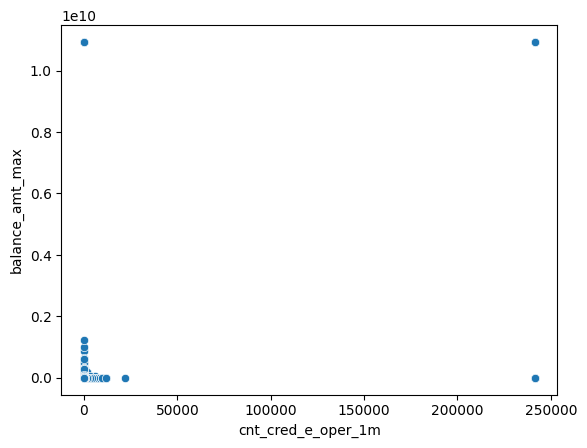

In [815]:
scatter_and_corr(train_df,'cnt_cred_e_oper_1m', 'balance_amt_max')

Correlation = 0.458322112733999


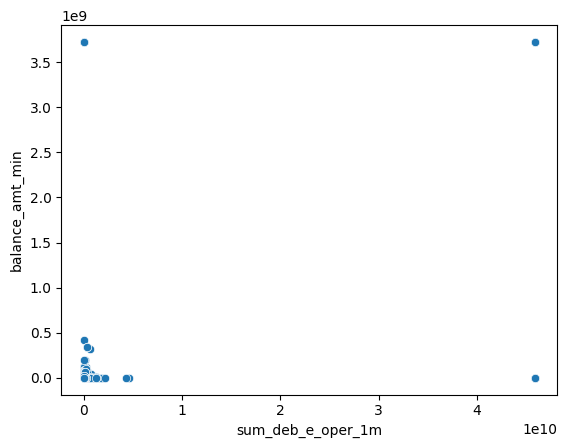

In [816]:
scatter_and_corr(train_df,'sum_deb_e_oper_1m', 'balance_amt_min')

In all three example we see a big and isolated outliers (that's very unnatural for continuos nature of our data). The logistic regression may struggle to interpolate these points. In addition to this issues, pearson correlation test gives biased numbers (after removing correlation may go lower and higher).

Correlation = -0.0034827666598204856


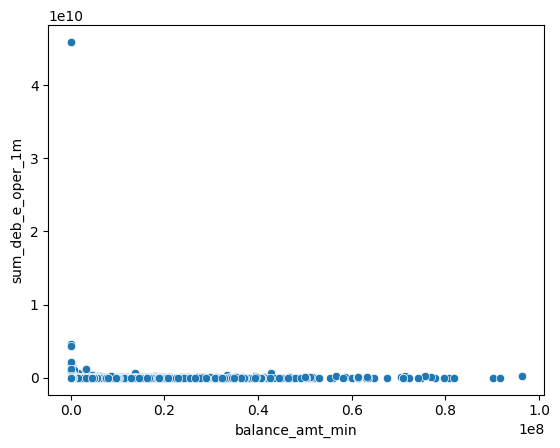

In [817]:
x = train_df[train_df['balance_amt_min'] < 100000000]
scatter_and_corr(x, 'balance_amt_min', 'sum_deb_e_oper_1m')

As another examples are (balance_amt_avg and balance_amt_max); (balance_avg_days_avg and balance_amt_avg), these pairs should correlate, but in data there is no correlation!

Correlation = -0.0014738089005927302


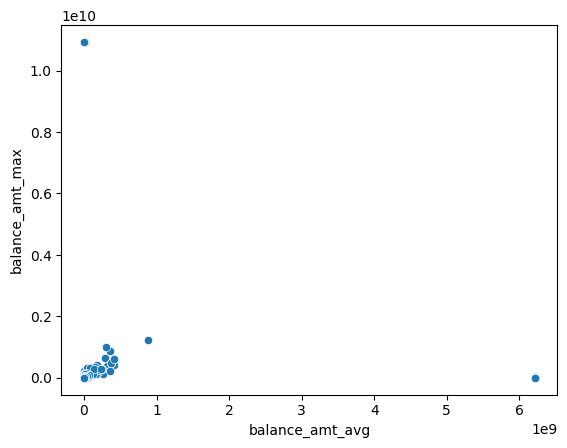

In [818]:
scatter_and_corr(train_df, 'balance_amt_avg', 'balance_amt_max')

Correlation = 0.8756131652380488


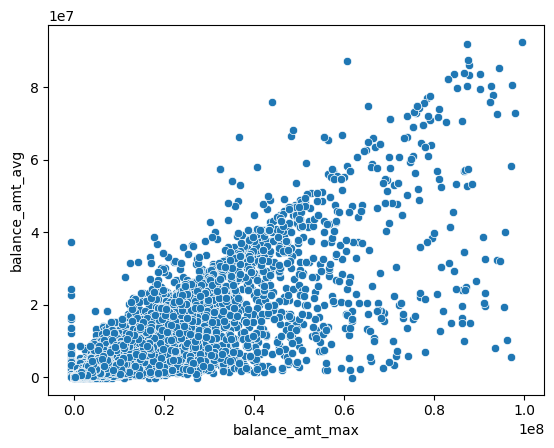

In [819]:
x = train_df[(train_df['balance_amt_max'] < 100000000) & (train_df['balance_amt_avg'] < 100000000)]
scatter_and_corr(x, 'balance_amt_max', 'balance_amt_avg')

Correlation = -0.002229994361735303


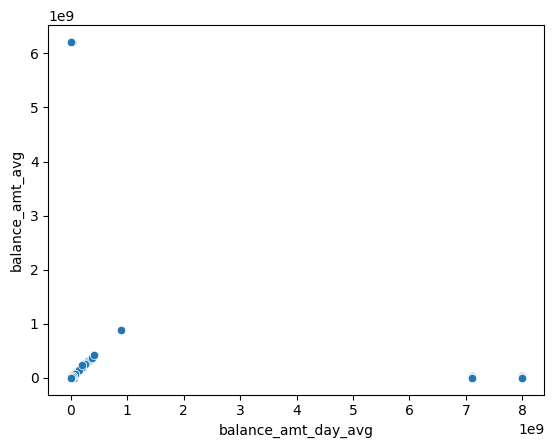

In [820]:
scatter_and_corr(train_df, 'balance_amt_day_avg', 'balance_amt_avg')

Correlation = 0.9985257037438232


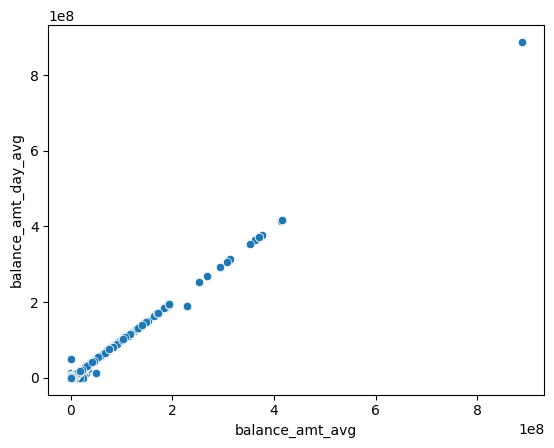

In [821]:
x = train_df[(train_df['balance_amt_avg'] < 1000000000) & (train_df['balance_amt_day_avg'] < 1000000000)]
scatter_and_corr(x, 'balance_amt_avg', 'balance_amt_day_avg')

**The justice** is restored!

That will be a problem on stage of removing correlated features for simpler interpretation of our models. Our team decided to find these points manually and replace them with NaNs. We will provide only the final results (upper bounds). Some of them may make sense like sum of operations being for 1 month being 1.000.000.000 roubles (which we think is impossible for russian companies)

In [822]:
upper_bounds = {
    
        'cnt_days_deb_e_oper_1m':35,
        'cnt_days_cred_e_oper_1m':35,
        'cnt_days_deb_f_oper_1m':35,
        'cnt_days_cred_f_oper_1m':35,
        'cnt_days_deb_g_oper_1m':35,
        'cnt_days_cred_g_oper_1m':35,
        'cnt_days_deb_h_oper_1m':35,
        'cnt_days_cred_h_oper_1m':35,
        
        'cnt_days_deb_e_oper_3m':100,
        'cnt_days_cred_e_oper_3m':100,
        'cnt_days_deb_f_oper_3m':100,
        'cnt_days_cred_f_oper_3m':100,
        'cnt_days_deb_g_oper_3m':100,
        'cnt_days_cred_g_oper_3m':100,
        'cnt_days_deb_h_oper_3m':100,
        'cnt_days_cred_h_oper_3m':100,
    
        'rko_start_months':792,
        
        'balance_amt_avg':1000000000,
        'balance_amt_max':10000000000,
        'balance_amt_min':1000000000,
        'balance_amt_day_avg':1000000000,
    
        'ft_registration_date':20000,
    
        'sum_of_paym_2m':10000000000,
        'sum_of_paym_6m':10000000000,
    
        'sum_a_oper_1m':10000000,
        'cnt_a_oper_1m':2000,
    
        'sum_b_oper_1m':10000000000,
        'cnt_b_oper_1m':100,
    
        'cnt_c_oper_1m':10000,
        'sum_deb_d_oper_1m':1000000000,
        
        'sum_cred_d_oper_1m':1000000000,
        'cnt_cred_d_oper_1m':1500,
        'sum_deb_e_oper_1m':10000000000,
        'cnt_deb_e_oper_1m':50000,
        'sum_cred_e_oper_1m':10000000000,
        'cnt_cred_e_oper_1m':10000,
        'cnt_deb_f_oper_1m':10000,
        'sum_cred_f_oper_1m':1000000000,
        'cnt_cred_f_oper_1m':10000,
        'cnt_deb_g_oper_1m':10000,
        'sum_deb_h_oper_1m':10000000000,
        'cnt_deb_h_oper_1m':10000,
        'sum_cred_h_oper_1m':10000000000,
        'cnt_cred_h_oper_1m':10000,
        'sum_a_oper_3m':100000000,
        'cnt_a_oper_3m':1000,
        'sum_b_oper_3m':10000000000,
        'cnt_b_oper_3m':1000,
        'sum_c_oper_3m':100000000,
        'cnt_c_oper_3m':10000,
        'sum_deb_d_oper_3m':1000000000,
        'cnt_deb_d_oper_3m':10000,
        'cnt_cred_d_oper_3m':10000,
        'cnt_deb_e_oper_3m':1000000,
        'sum_cred_e_oper_3m':10000000000,
        'cnt_cred_e_oper_3m':100000,
        'sum_deb_f_oper_3m':1000000000,
        'cnt_deb_f_oper_3m':100000,
        'sum_cred_f_oper_3m':1000000000,
        'cnt_deb_g_oper_3m':10000,
        'sum_cred_g_oper_3m':10000000000,
        'sum_deb_h_oper_3m':10000000000,
        'sum_cred_h_oper_3m':10000000000,
        
    }

# Final numeric features code

In [823]:
def clean_data(X):

    object_columns = X.columns[X.dtypes == 'object']

    cnt_days_one_columns = [col for col in X.columns if ('cnt_days' in col) & ('1m' in col)]
    cnt_days_three_columns = [col for col in X.columns if ('cnt_days' in col) & ('3m' in col)]

    for column in X.columns:
        if column not in object_columns:
            
            outlier_filter = X[column] < 0

            if column in upper_bounds.keys():
                outlier_filter = outlier_filter | (X[column] > upper_bounds[column])       
                                                  
            X.loc[outlier_filter, column] = np.NaN

    return X

In [824]:
def drop_num_features(X):
    # Drop Feature with bgi % of nan values
    X = X.drop(columns=[col for col in X.columns if ('deals' in col) | ('founder' in col)])

    # Drop irrelevant features
    X = X.drop(columns=['ogrn_days_end_month', 'ogrn_days_end_quarter', 'cnt_cred_f_oper_1m', 'cnt_cred_f_oper_3m'], errors='ignore')

    return X

In [825]:
train_df = clean_data(train_df)
train_df = drop_num_features(train_df)

# Remove cluster of strange people
train_df = train_df[~train_df.index.isin(nan_people.index)]

# Category features

## NaN check

In [826]:
train_df.select_dtypes(include='object').isna().sum() / train_df.shape[0]

channel_code       0.021549
city               0.277148
city_type          0.277148
index_city_code    0.572447
ogrn_month         0.001202
ogrn_year          0.001202
branch_code        0.000000
okved              0.001372
segment            0.000040
dtype: float64

There are 3 feature which NaN ration is higher highter than ~27%. The possible solutions are similar to NaNs in numeric features. The important thing to keep in mind, that categorical features has NaN encoded as python None (not np.NaN)

## City and city_type relationship

In this part we investigate product of 2 categorical features: city and city_type. First assumption was that each city has only one city type. But it isn't true for the majority of data.

In [827]:
train_df.groupby('city').city_type.nunique().rename('number_of_city_types').value_counts()

number_of_city_types
1    6759
2    1324
3     111
4      21
5       1
9       1
Name: count, dtype: int64

Then we decided to look from the other side - number of unique cities for each city_type.

In [828]:
train_df.groupby('city_type').city.nunique().rename('number of unique cities').value_counts()

number of unique cities
1       6754
4          4
2          3
6          3
69         1
593        1
38         1
8          1
7          1
1037       1
108        1
332        1
20         1
19         1
23         1
308        1
15         1
5          1
445        1
17         1
Name: count, dtype: int64

Almost all city types are useless, because have only a few towns. We had a theory that these city types may belong city with over a million people. To check if it's true we can add count for each city_type. We expect that these city types have only a few cities by appear a lot (because it's large towns)

In [829]:
city_type_info = train_df.groupby('city_type').agg({'city':['count', 'nunique']})
city_type_info.columns = ['count', 'unique_cities']
city_type_info.sort_values('count', ascending=False).head(20)

,count,unique_cities
city_type,,
3597,208614,1037
1252,21743,593
727,747,445
5418,744,308
3844,534,332
1145,291,108
1606,157,69
2240,148,1
5369,117,23


By these theory crashes, because there are no city_types with large count, but small unique towns counts. Given this table, we can take in account only a few city types like '3597', '1252'. Thus these feature can be easily encoded using One Hot Encoding.

In [830]:
def print_type_target(city_type):
    print(f"""
        Mean target of city_type == {city_type} {train_df[train_df['city_type'] == city_type].total_target.mean()}
        Mean target of city_type != {city_type} {train_df[train_df['city_type'] != city_type].total_target.mean()}
    """)

In [831]:
print_type_target('3597')


        Mean target of city_type == 3597 0.04713969340504472
        Mean target of city_type != 3597 0.10295792634521796
    


In [832]:
print_type_target('1252')


        Mean target of city_type == 1252 0.09529503748332797
        Mean target of city_type != 1252 0.06835857428798804
    


## Channel code

This feature has a lot of unique values, which leads to 2 main problems:

- One Hot Encoding representation will be really sparse, with a lot of rare categories.
- Some of channels might not be present in train, but will be in test.

To mitigate this issue we could explore only top-k frequent values. We suggest to take all top-15 categories (more than ~1.8% of occurence). The choice of threshold can be system hyperparameter. For less frequent or unknown groups we will create category others. This is important for filter out small groups that are not representative.

In [833]:
def plot_top_k_encoding(df, top_k, column_name):
    
    df = df.copy()
    
    column_counts = df[column_name].value_counts(normalize=True)
    
    frequent_values = list(column_counts.iloc[:top_k].index)
    
    column = df[column_name]
    column[~column.isin(frequent_values) & column.notna()] = 'other'
                            
    df.loc[:, column_name] = column
    
    frequent_values = frequent_values + ['other']
    
    column_target = df.groupby(column_name).total_target.mean()
    
    sns.barplot(x=column_target.index, y=column_target, order=frequent_values)

In [834]:
channel_top_k = 15

/tmp/ipykernel_47/3129123597.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[~column.isin(frequent_values) & column.notna()] = 'other'


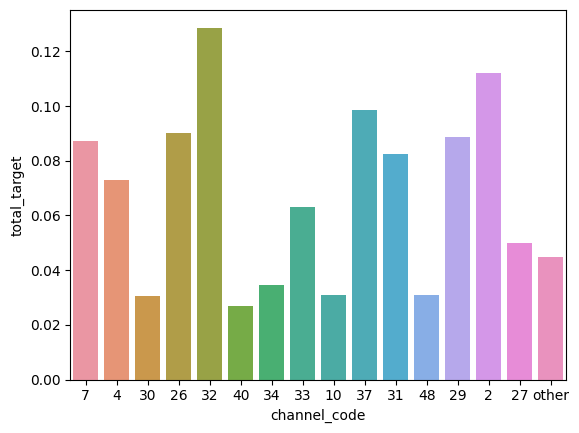

In [835]:
plot_top_k_encoding(train_df, channel_top_k, 'channel_code')

The channel codes are ordered by their frequency with other channels at the end. There is no clear relationship between frequency and target variable, so frequency encoding might be a ba choice, target and one hot encodings might be more suitable.

## Relevance of ogrn_month and ogrn_year

Both variable will be encoded using ordinal encoding

The common sense gives us a hint that periodic feature wouldn't influence the target variable. It doesn't tell us anything about the company and possible bring noise to data. On the other hand ogrn_year could tell us about its experience.

In [ ]:
train_df['ogrn_month'] = pd.to_numeric(train_df['ogrn_month'])
train_df['ogrn_year'] = pd.to_numeric(train_df['ogrn_year'])

In [ ]:
train_df['total_target']

In [ ]:
train_df.loc[train_df.total_target == 1, 'ogrn_month']

In [ ]:
fig, axarr = plt.subplots(figsize=(8, 4))

sns.histplot(x=train_df.loc[train_df.total_target == 1, 'ogrn_month'], stat='probability', binwidth=1)
sns.histplot(x=train_df.loc[train_df.total_target == 0, 'ogrn_month'], stat='probability', binwidth=1)
plt.title('ogrn_month disctribution for both target values')

The distributions don't differ too much, that's  a bad discriminative feature as we suggested.

In [ ]:
sns.boxplot(data=train_df, y='ogrn_year', x='total_target')

Newer companies (that register closer to 2020) are more likely to come from churn distribution.

## City and index_city_code

At first glance, both city and index_city_code contains the same information about the location. We decided to check if each city has one and only one index_city_code and vise versa (which makes sense).

In [ ]:
train_df.groupby('city').index_city_code.nunique().rename('unique index codes').value_counts()

In [ ]:
train_df.groupby('index_city_code').city.nunique().rename('unique cities').value_counts().head(10)

As we can see, the relationship is very inconsistent - in addition to this index has a ~66% of NaN values. Our team decided to drop that suspicious feature.

## okved

Here we apply the same strategy as with channel codes.

In [ ]:
okved_top_n = 20

In [ ]:
plot_top_k_encoding(train_df, okved_top_n, 'okved')

In addition to no frequency relationship, the discriminative power of this feature is weaker (the difference between different bars' heights). We will try both target and one hot encoding in modeling part.

## Segment

That feature is much more simpler, because it has only 4 unique values. One Hot Encoding will be sifficient.

In [ ]:
segment_target = train_df.groupby('segment').total_target.mean()

In [ ]:
sns.barplot(x=segment_target.index, y=segment_target)

One segment is very likely to leave the bank. We could check total sum of payments for different periods to assume what type of people they are. That will in a different section for business insights.

## Branch Code and City

In opinion of our team these 2 variables carry only geo and historical information (if the the departament was doing bad or good for a long time) and can't carry high-level information about pattern. In addition to it these features has high cardinality, that assumes usage of target encoding.

# Final categorical feature code

In [ ]:
def drop_cat_features(df):
    
    return df.drop(columns=['index_city_code', 'ogrn_month', 'city', 'branch_code'], errors='ignore')

In [ ]:
train_df = drop_cat_features(train_df)

# Feature Engineering

In [ ]:
def get_sum_of_paym_ratio_features(df):
    
    sum_of_paym_12_6 = df['sum_of_paym_1y'] - df['sum_of_paym_6m']
    sum_of_paym_6_2 = df['sum_of_paym_6m'] - df['sum_of_paym_2m']
    
    df['sum_of_paym_ratio_1'] = sum_of_paym_12_6/sum_of_paym_6_2
    df['sum_of_paym_ratio_2'] = sum_of_paym_6_2/df['sum_of_paym_2m']
    
    return df

In [ ]:
unilateral_oper = ['a', 'b', 'c']
bilateral_oper = ['d', 'e', 'f', 'g', 'h']

periods = ['1m', '3m']

def get_deb_cred_ratio_features(df):
    
    for oper in bilateral_oper:
        for period in periods:
            df[f'deb_cred_{oper}_{period}_ratio'] = df[f'sum_cred_{oper}_oper_{period}'] / df[f'sum_deb_{oper}_oper_{period}']
    
    return df

In [ ]:
def get_features(df):
    
    df = get_sum_of_paym_ratio_features(df)
    df = get_deb_cred_ratio_features(df)
    df = 
    
    return df

In [ ]:
train_df = get_features(train_df)

# Target Distibution

Using balanced weights for each class might be an appropriate desicion

In [ ]:
train_df['total_target'].mean()

As for additional targets (total_target = max(target_1, target_2)), their estimation would be a multilabel task. Given the prediction, we could aggregate them (mean, weighted mean, stacking) to get the final answer. We believe that more complex approach for predicting total target can give better results. 

In [ ]:
train_df.groupby(['target_1', 'target_2']).size()

# Train Holdout Split

The holdout part will be useful for

- Performing feature improtance calculation (based on permutation importance and SHAP values that are useful for non-interpretable models)
- Evaluation our model perfomance using different metrics
- Stacking our model for final submission

The size was chosen to be the same as public and private leaderboard (50000 samples), stratified option is used.

Small portion of data will be used for independent analisys of relevant uncorrelated features. Using seperate data part for feature removal will give us unbiased estimates of model perfomance, because election and training will be 2 seperate processes. In addition to this, we can calculate all statistics for target encoding for categorical features without any data leakage.

In [ ]:
df, df_holdout = train_test_split(train_df, test_size=50000, stratify=train_df['total_target'], random_state=42)

In [ ]:
X = df.drop(columns=['total_target','target_1', 'target_2'])
y = df['total_target']
y_multi = df[['target_1', 'target_2', 'total_target']]

In [ ]:
x_test = pd.read_parquet('/kaggle/input/alpha-contest/test.parquet').set_index('id')
x_test = drop_cat_features(x_test)
x_test = drop_num_features(x_test)
x_test = get_features(x_test)

In [ ]:
X['dataset'] = 0
X_test['dataset'] = 1

In [ ]:
r = pd.concat([X, X_test], axis=0)
x, x_holdout = train_test_split(r, test_size=100000, shuffle=True, random_state=42)

In [ ]:
x.shape, x_holdout.shapу

# Interpretable model

## Feature correlation

Multicollinear features is a problem, because interpretation of our features becomes hard (feature importance is spread across correlated features).

To deals with it we iterate over features and all the features that correlate with current more than a given threshold. The suggsted threshold is 0.5 - strong correlation

In [ ]:
CORR_THRESHOLD = 0.5

In [ ]:
%%time
# takes some time
X_num = X.select_dtypes(include='number')
corr = X_num.corr(method='pearson').abs()

In [ ]:
corr.style.background_gradient()

Let's look at the most correlating pairs!

In [ ]:
corr_pairs = []

for i in range(0, corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        
        if corr.iloc[i, j] > CORR_THRESHOLD:
            corr_pairs.append((X_num.columns[i], X_num.columns[j], corr.iloc[i, j]))

corr_pairs.sort(key = lambda t : t[2], reverse=True)

In [ ]:
N = len(corr_pairs[:10])
fig, axarr = plt.subplots(nrows=N, figsize=(10, 6*N))

for i in range(N):
    pair = corr_pairs[i]
    cur_ax = axarr[i]
    sns.scatterplot(x=X_num[pair[0]], y=X_num[pair[1]], ax=cur_ax)
    cur_ax.set_title(pair[2])

In [ ]:
corr_table = corr.unstack().drop_duplicates().reset_index()
corr_table.columns = ['feature_1', 'feature_2', 'corr']
corr_table = corr_table[corr_table['feature_1'] != corr_table['feature_2']]
corr_table = corr_table[corr_table['corr'] > CORR_THRESHOLD]

In [ ]:
corr_rel = defaultdict(list)

for i in range(corr_table.shape[0]):

    corr_rel[corr_table.iloc[i, 0]].append(corr_table.iloc[i, 1])
    corr_rel[corr_table.iloc[i, 1]].append(corr_table.iloc[i, 0])

In [ ]:
selected_num_features = []
banned_features = set()

for feature in X_num.columns:
    
    if feature not in banned_features:
        selected_num_features.append(feature)
        
        for to_ban in corr_rel[feature]:
            banned_features.add(to_ban)
        
print(f"""
      {X_num.shape[1]} num features before correlation removal
      {len(selected_num_features)} num features after correlation removal
""")

In [ ]:
selected_features = selected_num_features + list(X.select_dtypes(include='object').columns)

In [ ]:
filtered_corr = X_num[selected_num_features].corr().abs()
filtered_corr.style.background_gradient()

In [ ]:
X_interpretable = X[selected_features]
X_interpretable.shape

## Model? Logistic Regression!

The first algorithm that comes to mind in terms of interpretability is a logistic regression! Model weights can show the importance of each feature and its impact on final prediction!

Our pipepline consists of several key points:

- Logistic Regression requires proper choice of standardization method and optimization solver. For our task the best choice, that would converge in a given number of iters was (MinMax Scaler + newton-cholesky solver)
- Median and most-frequent imputations were used for numeric and categorical features accordingly.
- OneHotEncoding for categorical features drop the first category to avoid collinearity.

In [ ]:
number_columns = list(X_interpretable.select_dtypes(include='number').columns)

In [ ]:
lr_model = make_pipeline(
    BinningProcess(variable_names=number_columns),
    LogisticRegression(solver='newton-cholesky', class_weight='balanced')
)

In [ ]:
lr_model = lr_model.fit(X_interpretable[number_columns], y)

## Model Coefficients

In [ ]:
coefs = np.squeeze(lr_model._final_estimator.coef_)

In [ ]:
pd.DataFrame({'coefs':coefs, 'number':number_columns})

In [ ]:
sns.barplot(y=number_columns, x=coefs)

In [ ]:
coefs = np.squeeze(lr_model._final_estimator.coef_)

## Holdout metric evaluation

In [ ]:
X_holdout = df_holdout.drop(columns=['target_1', 'target_2', 'total_target'])
y_holdout = df_holdout['total_target']

In [ ]:
X_holdout = X_holdout[num_columns]

In [ ]:
y_pred = lr_model.predict_proba(X_holdout)[:, 1]

In [ ]:
sns.histplot(y_pred)

In [ ]:
roc_auc_score(y_holdout, y_pred)

In [ ]:
2*roc_auc_score(y_holdout, y_pred)-1

In [ ]:
confusion_matrix(y_holdout, y_pred > 0.5)

In [ ]:
true_pred_table = pd.DataFrame({'y_pred':(y_pred > 0.5).astype(int), 'y_true':y_holdout})

In [ ]:
left = X_holdout[(true_pred_table['y_pred'] == 0) & (true_pred_table['y_true'] == 1)].index

In [ ]:
train_df.loc[left]['sum_of_paym_2m'].sum()